# Early Data Analysis of Essay Data

In [1]:
import matplotlib
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
# read in our data 
essay_df = pd.read_csv("datasets/training_set_rel3.tsv", delimiter = "\t")

In [3]:
essay_df.head(2)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
essay_df.shape

(12976, 28)

In [4]:
# Vectorize the essays within each dataset

# We use ignore for decode_error because our data is in a 
# different byte format then CountVectorizer is used to 
vectorizer = CountVectorizer(stop_words="english", min_df=4, decode_error="ignore")
corpus = essay_df['essay'].values
essay_vector = vectorizer.fit_transform(corpus)
essay_vector = essay_vector.toarray()

In [5]:
# domain1_score is the resolved scores between the two 
# graders in case of disagreement 
domain1_scores = essay_df['domain1_score'].values

# Comparing Essay Size with Score 

In [57]:
# note that this is the length of essays NOT including the stop words.
# This assumes that the number of stop words doesn't relate much to 
# the content or grading of the essay 
lengths_of_essays = np.array([sum(vector) for vector in essay_vector])

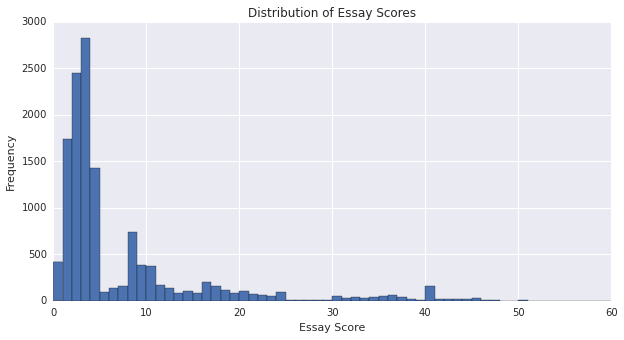

In [79]:
# Let's take a look at the distribution of essay scoress
# for all essay sets
plt.figure(figsize=(10, 5))
plt.hist(domain1_scores, bins=60)
plt.title("Distribution of Essay Scores")
plt.xlabel("Essay Score")
plt.ylabel("Frequency")

As we can see from the above, it looks as if the most frequent score is about a 3 or 4, and the distribution varies widely. But before we draw any conclusions, not that the grading scale is different for all 8 essay sets! We'll either need to normalize essay scores or split up any analysis we do across all 8 essay sets. Let's take a look at the distributions of essay scores partitioned of set.

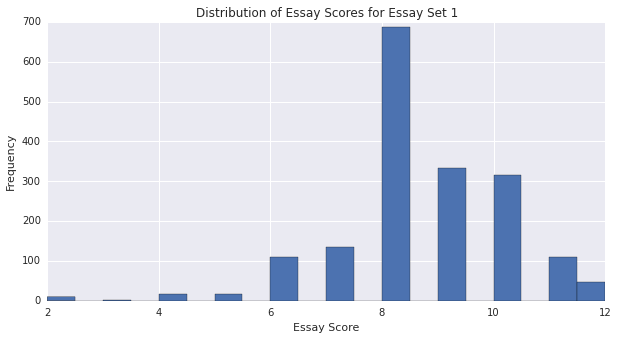

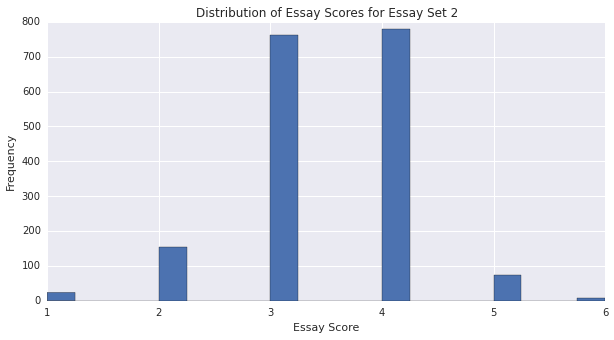

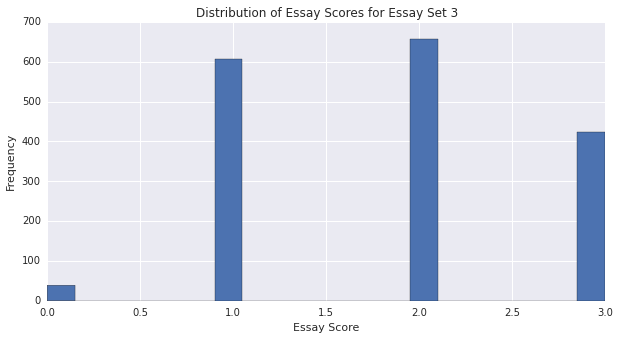

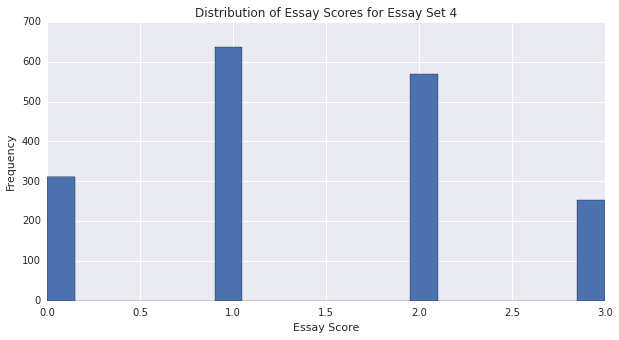

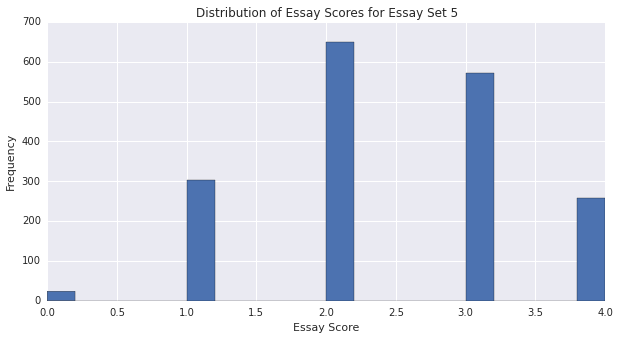

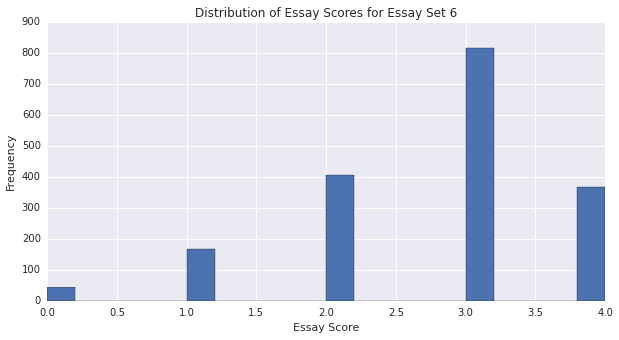

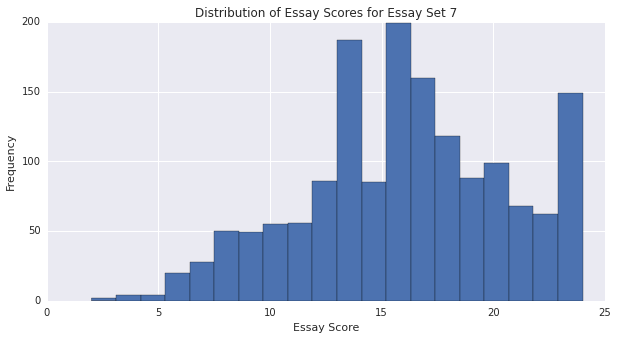

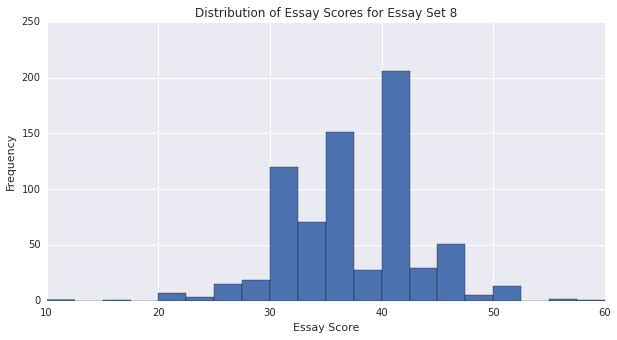

In [86]:
essay_set_ids = essay_df["essay_set"].unique()

for essay_set_id in essay_set_ids:     
    plt.figure(figsize=(10, 5))
    plt.hist(essay_df[essay_df["essay_set"] == essay_set_id]['domain1_score'].values, bins=20)
    title = "Distribution of Essay Scores for Essay Set {0}".format(essay_set_id)
    plt.title(title)
    plt.xlabel("Essay Score")
    plt.ylabel("Frequency")

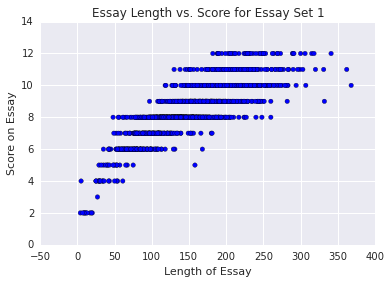

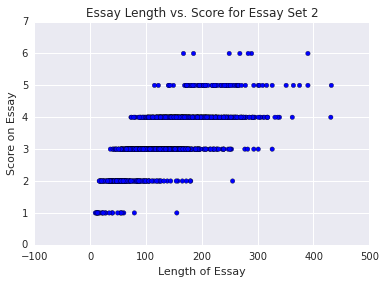

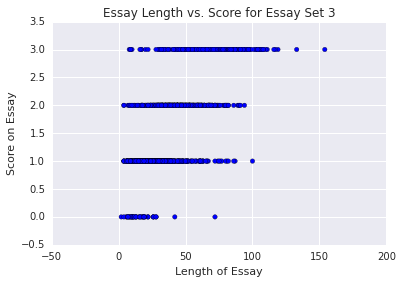

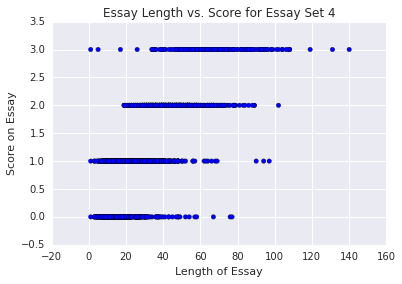

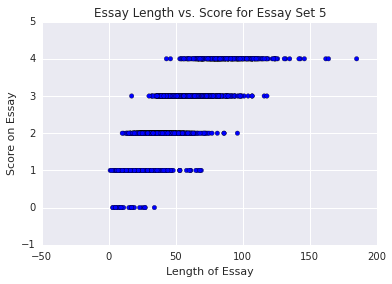

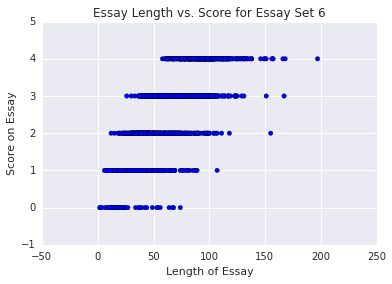

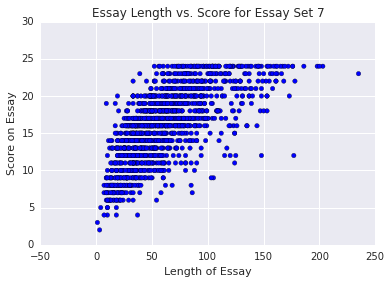

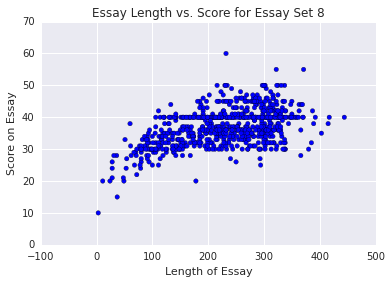

In [88]:
essay_set_ids = essay_df["essay_set"].unique()

for essay_set_id in essay_set_ids: 
    essay_set_df = essay_df[essay_df["essay_set"] == essay_set_id]
    
    vectorizer = CountVectorizer(stop_words="english", min_df=4, decode_error="ignore")
    corpus = essay_set_df['essay'].values
    x = vectorizer.fit_transform(corpus)
    x = x.toarray()
    
    domain1_scores = essay_set_df['domain1_score'].values
    lengths_of_essays = np.array([sum(vector) for vector in x])
    
#     temp_y = domain1_scores[np.where(essay_df["essay_set"] == essay_set[essay_set_id - 1])]
#     temp_length = lengths_of_essays[np.where(essay_df["essay_set"] == essay_set[essay_set_id - 1])]

    plt.scatter(lengths_of_essays, domain1_scores)
    
    title = "Essay Length vs. Score for Essay Set {0}".format(essay_set_id)
    plt.title(title)
    plt.savefig("figures/" + title + ".jpg")
    plt.xlabel("Length of Essay")
    plt.ylabel("Score on Essay")
    plt.show()

There appears to be a positive relationship between scores and number of words for essays within the same set, though this relationship is not the same for each set.

# Number of Unique Words vs. Score 

In [58]:
# Counts the number of unique words
num_unique_words  = np.array([np.count_nonzero(i) for i in essay_vector])

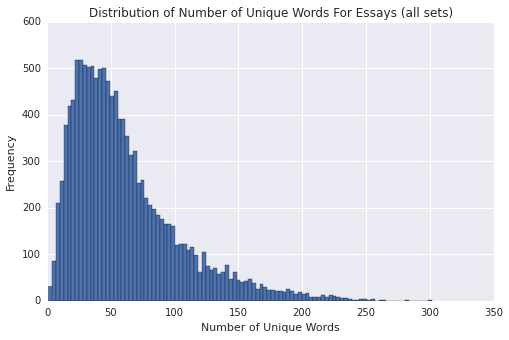

In [63]:
plt.figure(figsize=(8,5))
plt.hist(num_unique_words, bins=100)
plt.title("Distribution of Number of Unique Words For Essays (all sets)")
plt.xlabel("Number of Unique Words")
plt.ylabel("Frequency")

It looks as if most students tend to use between 0 and ~100 unique words per essay. Let's see if this number correlates with essay score.

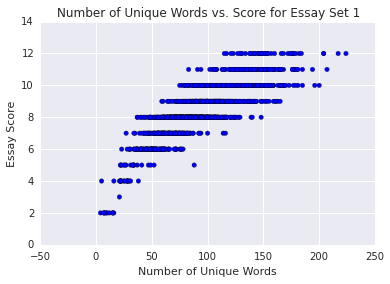

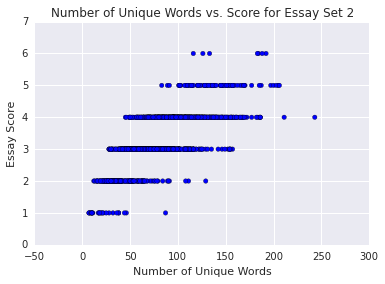

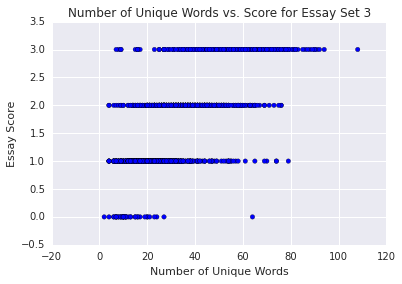

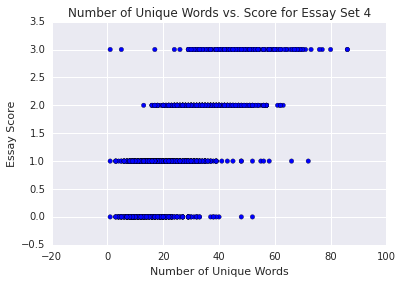

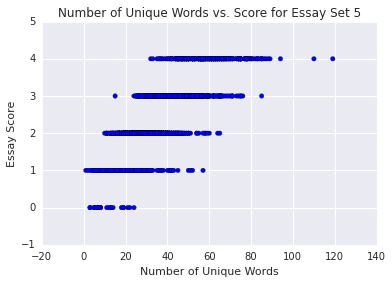

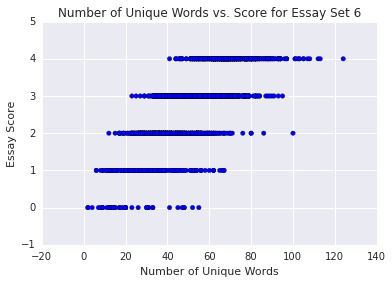

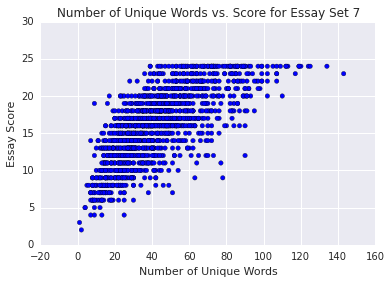

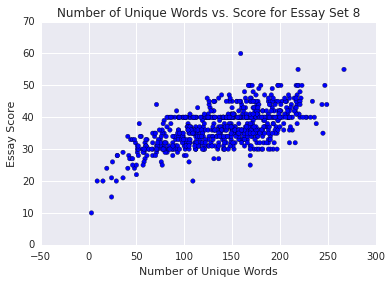

In [89]:
essay_set_ids = essay_df["essay_set"].unique()

for essay_set_id in essay_set_ids: 
    essay_set_df = essay_df[essay_df["essay_set"] == essay_set_id]
    
    vectorizer = CountVectorizer(stop_words="english", min_df=4, decode_error="ignore")
    corpus = essay_set_df['essay'].values
    x = vectorizer.fit_transform(corpus)
    x = x.toarray()
    
    domain1_scores = essay_set_df['domain1_score'].values
    num_unique_words  = np.array([np.count_nonzero(i) for i in x])
    
#     temp_y = domain1_scores[np.where(essay_df["essay_set"] == essay_set[essay_set_id - 1])]
#     temp_length = lengths_of_essays[np.where(essay_df["essay_set"] == essay_set[essay_set_id - 1])]

    plt.scatter(num_unique_words, domain1_scores)
    
    title = "Number of Unique Words vs. Score for Essay Set {0}".format(essay_set_id)
    plt.title(title)
    plt.savefig("figures/" + title + ".jpg")
    plt.xlabel("Number of Unique Words")
    plt.ylabel("Essay Score")
    plt.show()

The histograms above look very similar to those of essay length vs. score, indicating that a high essay length can likely be used as a proxy for number of unique words, especially given that we weren't including stopwords in our calculations of essay length. That is, when we take out basic words ("the", "a", etc.), then most words used in the essays are only used once!

## Correlation Between Expert Judgement 
Let's explore how correlated our experts choices are. We'll do this by using rater1_domain1 and rater2_domain2 values in the dataframe. 

In [142]:
np.corrcoef(essay_df["rater1_domain1"], essay_df["rater2_domain1"])

array([[ 1.        ,  0.96932615],
       [ 0.96932615,  1.        ]])

The scores for both judges are very strongly correlated (0.97), indicating strong interrater reliability.